In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, LatentDirichletAllocation
import emoji
from tqdm import tqdm
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

In [4]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
emoji_vectors = pd.read_pickle("emoji_vectors_data.pkl")
topic_scores = pd.read_pickle("topic_scores_df.pkl")
emotion_scores = pd.read_csv("tweet_emotions.csv")
tweets = pd.read_csv("tweets_data.csv", parse_dates=["created_at"]).dropna(subset=["tweet_id"])

All the emoji ids and the emojis

In [6]:
for eid in emoji_vectors.emoji_id.unique():
    print(eid, emoji.EMOJI_UNICODE_ENGLISH[tokenizer.convert_ids_to_tokens([eid])[0]])

871 ☺️
1585 ♀️
2555 ♂️
1672 ✌️
1658 ✨
280 ❤️
1696 🎉
1315 🏻
1277 🏽
1715 👀
820 👌
1055 👍
1320 👏
1651 💀
3183 💋
2507 💔
663 💕
1548 💖
1919 💗
3026 💘
1759 💙
3581 💚
2968 💛
1376 💜
2749 💞
1088 💯
1382 🔥
838 😁
88 😂
1411 😅
1322 😉
518 😊
390 😍
1022 😏
908 😔
722 😘
491 😩
247 😭
1107 😳
1138 🙄
1663 🙈
1152 🙌
933 🙏
1422 🤣
2541 🤦
2144 🤷
6239 🥺


This class is an essentially one-stop shop that hosts all the data and functions used in the clustering prayer hands notebook.

In [7]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}".format(topic_idx+1))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [136]:
class ClusterHub:    
    
    def __init__(self, emoji_id, model_class, model_params = None, sample_frac = None):
        self.emoji_id = emoji_id
        self.emoji_token = tokenizer.convert_ids_to_tokens([emoji_id])[0]
        self.emoji = emoji.EMOJI_UNICODE_ENGLISH[self.emoji_token]
        self.emoji_df = emoji_vectors.query("emoji_id == {}".format(emoji_id)).drop("emoji_id", axis = 1)
        self.sampled = False
        
        self.emoji_df = pd.merge(self.emoji_df, tweets, on = "tweet_id")
        self.embeddings = self.emoji_df.embedding
        self.embeddings = self.embeddings.apply(pd.Series)
        self.tsne = False
        
        if sample_frac:
            self.sampled = True
            self.embeddings_sample = self.embeddings.sample(frac = sample_frac)
            
        self.model_class = model_class
        self.model_params = model_params
        self.models = {}
        self.model_labels = {}
        self.silhouette_scores = {}
        self.tsne_embeddings = None
        self.text = self.emoji_df.groupby("tweet_id").text.unique().apply(lambda x:x[0])
        
    def plot_tweet_rate(self, period = "M"):
        tweet_rate = pd.Series(index=pd.to_datetime(self.emoji_df.created_at)).sort_index()
        tweet_rate.resample(period).size().plot(figsize = (9,6))
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.title(f"{period} Tweeting Rate of the {self.emoji_token} Emoji")
        
    def cluster_range(self, k_range=(2, 21)):
        
        for k in tqdm(range(*k_range)):
            if self.model_params:
                model = self.model_class(n_clusters = k, **self.model_params)
            else:
                model = self.model_class(n_clusters = k)
            
            if self.sampled:
                model.fit(self.embeddings_sample)
                self.model_labels[k] = model.predict(self.embeddings)
                sil_score = silhouette_score(self.embeddings_sample, model.labels_)
            else:
                model.fit(self.embeddings)
                self.model_labels[k] = model.labels_
                sil_score = silhouette_score(self.embeddings, model.labels_)

            self.models[k] = model
            self.silhouette_scores[k] = sil_score
            
    def labels_freq_prop(self, k):
        labels = self.model_labels[k]
        freq = pd.value_counts(labels)
        prop = pd.value_counts(labels, normalize=True)
        return pd.concat([freq, prop], axis = 1).sort_index().rename(columns={0:"Frequency", 1:"Proportion"})
            
    def plot_silhouette_scores(self):
        
        if len(self.silhouette_scores) == 0:
            raise ValueError("You need calculate the silhouette scores first")
            
        xvals = list(self.silhouette_scores.keys())
        yvals = list(self.silhouette_scores.values())
        plt.plot(xvals, yvals)
        plt.xlabel("K Values")
        plt.ylabel("Silhouette Scores")
        plt.xticks(ticks = xvals);
        
        

            
    def plot_tsne(self, k):
        
        if self.tsne == False:
            tsne = TSNE(random_state=10)
            if self.sampled:
                self.tsne_embeddings = tsne.fit_transform(self.embeddings_sample)
            else:
                self.tsne_embeddings = tsne.fit_transform(self.embeddings)
                
            self.tsne = True
            
        if self.sampled:
            labels = self.models[k].predict(self.embeddings_sample)
        else:
            labels = self.model_labels[k]
        
        tsne1 = self.tsne_embeddings[:, 0]
        tsne2 = self.tsne_embeddings[:, 1]
            
        sb.scatterplot(x = tsne1, y = tsne2, hue=labels, alpha = .5, palette = 'deep')
        plt.xlabel('TSNE Dimension 1')
        plt.ylabel('TSNE Dimension 2')
        plt.show()
        
    
    def return_tweet_ids_k_clusters_df(self, k):
        return self.emoji_df.assign(labels = self.model_labels[k]).set_index("tweet_id").labels
    
    def return_text_cluster_label(self, k, label):
        label_df = return_tweet_ids_k_clusters_df(k)
        cluster_ids = label_df[label_df.loc[:, k] == 1].index
        cluster_text = self.emoji_df[self.emoji_df.tweet_id.isin(cluster_ids)].text
        return cluster_text

    
    def topic_model(self, n_topics = 3, max_df = .4, min_df = 0.001):
    
        countvec = CountVectorizer(max_df=max_df, min_df=min_df,
                                   preprocessor=tokenizer.normalizeTweet, stop_words="english")
        
        dtm = countvec.fit_transform(self.text).toarray()
        features = countvec.get_feature_names()
        lda = LatentDirichletAllocation(n_components=3, random_state=0)
        self.topics = lda.fit_transform(dtm)
        display_topics(lda, features, 10)
        
    def print_sample_tweets_topics(self, n= 5):
        
        text_with_topics = self.text.to_frame().assign(topic = self.topics.argmax(axis = 1))
        for g in text_with_topics.groupby("topic"):
            print("Topic {}:\n\n==>".format(g[0]+1),"\n==>".join(g[1].text.sample(n).tolist()), "\n", "=="*50,"\n")
            
    def topics_and_clusters(self, k):
        text_with_topics = self.text.to_frame().assign(topic = self.topics.argmax(axis = 1))
        
        label_df = self.return_tweet_ids_k_clusters_df(k).to_frame()
        label_df = label_df.join(text_with_topics.topic)
        concatenated_df = None
        for i in range(k):
            prop = label_df[label_df.loc[:, i]==1].topic.value_counts(normalize=True).sort_index()
            if concatenated_df is None:
                concatenated_df = prop
                continue
            concatenated_df = pd.concat([concatenated_df, prop], axis = 1)
        concatenated_df.columns = ["Topic Proportions for Cluster {}".format(i) for i in range(k)]
        return concatenated_df
    
    def visualize_clusters_over_time(self, k):
        label_df = return_tweet_ids_k_clusters_df(k)
        emoji_time = self.emoji_df[["tweet_id","created_at"]].set_index("tweet_id")
        label_df = label_df.join(emoji_time)
        label_tweetrate = label_df.set_index("created_at")
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

        monthly_rate = label_tweetrate.resample("M").sum()
        monthly_rate.plot(ax = axes[0])

        axes[0].set_title('Tweet Rate for Each Cluster')

        monthly_rate.plot(kind = "area", ax = axes[1])

        axes[1].set_title('Stacked Area Plot for Tweet Rate')

        monthly_rate.divide(monthly_rate.sum(axis = 1),axis = 0).plot(kind = "area", ax = axes[2])

        axes[2].set_title('Stacked Proportions Area Plot for Tweet Rate')
        axes[2].set_ylim(0, 1)
        # plt.xlabel("Time")
        # plt.ylabel("Frequency")
        # plt.title("Monthly Tweeting Rate of the Prayer Hands Emoji");
        
    def open_source_model_analysis(self, model_scores_df, k):
        label_df = return_tweet_ids_k_clusters_df(k)
        mean_scores = model_scores_df.loc[label_df[label_df.loc[:, 0] == 1].index].mean().to_frame()

        for i in range(1, k):
            mean_scores_lab = topic_scores.loc[label_df[label_df.loc[:, i] == 1].index].mean().to_frame()
            mean_scores = pd.concat([mean_scores, mean_scores_lab], axis = 1)

        mean_scores.columns = ["cluster{}".format(i) for i in range(1, k+1)]
        return mean_scores

## Model 1: 


Emoji = Skull

Model = KMeans

Sampling = None



In [137]:
crying_km = ClusterHub(1651, KMeans)

/var/folders/lj/w4hy005d5vx9qy3lrwz0xdl80000gn/T/ipykernel_68881/3245778628.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tweet_rate = pd.Series(index=pd.to_datetime(self.emoji_df.created_at)).sort_index()


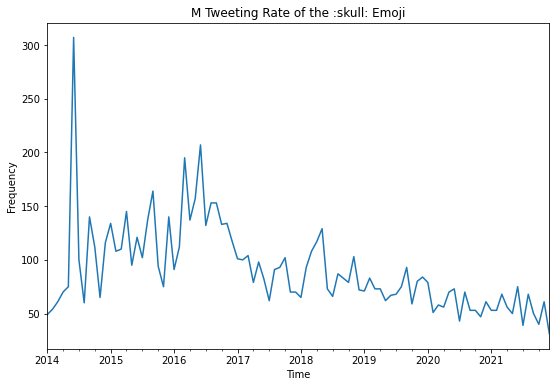

In [125]:
crying_km.plot_tweet_rate()

In [138]:
crying_km.cluster_range((2, 11))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.70s/it]


In [114]:
crying_km.labels_freq_prop(2)

,Frequency,Proportion
0,4268,0.489001
1,4460,0.510999


In [115]:
crying_km.labels_freq_prop(5)

,Frequency,Proportion
0,1783,0.204285
1,2357,0.270050
2,1442,0.165215
3,1383,0.158456
4,1763,0.201994


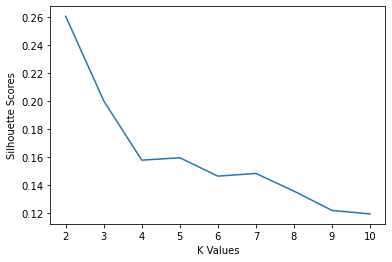

In [116]:
crying_km.plot_silhouette_scores()

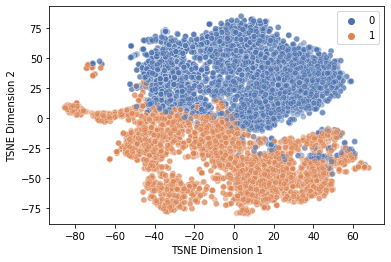

In [117]:
crying_km.plot_tsne(2)

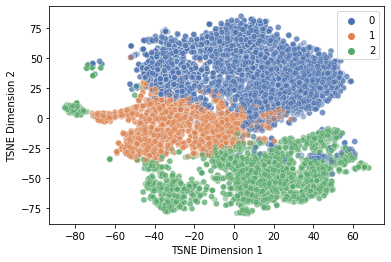

In [118]:
crying_km.plot_tsne(3)

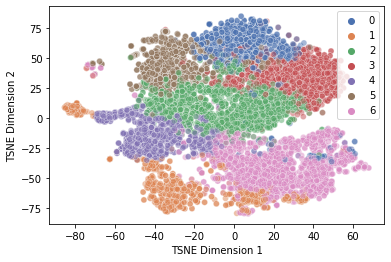

In [119]:
crying_km.plot_tsne(7)

In [139]:
crying_km.topic_model()

Topic 1
HTTPURL like just got know said shit did My rolling_on_the_floor_laughing
Topic 2
HTTPURL You medium dark_skin_tone red_heart bitch ass funny medium_skin_tone love
Topic 3
loudly_crying_face HTTPURL eyes weary_face dead rolling_on_the_floor_laughing smiling_face_with_heart sparkles cherry_blossom sleeping_face


In [140]:
crying_km.print_sample_tweets_topics()

Topic 1:

==> Every time I see this foo, I get a little hurt 😂 my co worker got the truck I was about to get 😂💀
==>@gzbpeter I'm going to end up buying the superior tickets though cuz I realized I still have bills to pay 😂😂😂😂💀💀💀💀
==>Not me seeing this post and my brain automatically calculating taxes and accessory costs to figure out how she didn’t spend everything he sent her 💀 Selling phones for a living has ruined me 😂 https://t.co/2ZE8dApjwL
==>I play with my tongue piercing way too much, that shit deadass fell out and I had to stick it back in 😭💀
==>@jasmiinelex @justinddiamond LMAO why am I just seeing this now 😂💀 

Topic 2:

==> lmaooo💀😂
==>he said suwoppp , but i might b a crip for dat pussy “ 💀😂😂😂😭😭😭 y'all gotta chill 🤦🏽‍♀️🤦🏽‍♀️🤦🏽‍♀️
==>@JalenBouldes 😂😂😂😂😂😂😂😂😂 BRUH! 💀 TRUE THO! lol 
I miss you!💜
==>@iamcristal14 @ramonamurillo_ @keshaunjordan Bro 😂 that hoe stay in the shop with busted bumper 💀
==>Justin asked Josh if he was asleep while he's sleeping 😭💀😂 https://t.co/c94klYZs

In [142]:
text_with_topics = crying_km.text.to_frame().assign(topic = crying_km.topics.argmax(axis = 1))
text_with_topics

,text,topic
tweet_id,,
429040748726861824,“@skylarwang: @Riverdale_Kee @kaedollaa_ @OneL...,0
429040782775816192,“@ChadVuitton: Don't you dare ladies http://t....,1
429040793718767616,“@realLOVE_last: Was Bruno girlfriend MAD OR S...,0
429040815105912832,“@kiakills_: #tbt freshman year 😭 @theninthpo...,2
429040919623774208,The group message be turnt 😂💀😈🙆💯 i be dead,2
...,...,...
1476704536068866048,"Whew chile, I need to come up with a schedule ...",0
1476704536618221568,How do you lot cope with mob @mobinta10 pest a...,0
1476704597834149888,RIP BOZO 💀💀💀💀 FLY HIGH 🕊️😭🚬🚬🚬 https://t.co/KZg...,2


In [154]:
label_df = crying_km.return_tweet_ids_k_clusters_df(3).to_frame().
label_df.head()

,labels
tweet_id,
615670367298953216,0
615670367298953216,0
615670367298953216,0
770772189989769216,0
770772296529121280,1


In [144]:
text_with_topics.topic

tweet_id
429040748726861824     0
429040782775816192     1
429040793718767616     0
429040815105912832     2
429040919623774208     2
                      ..
1476704536068866048    0
1476704536618221568    0
1476704597834149888    2
1476704646102196224    1
1476704650095214592    0
Name: topic, Length: 6292, dtype: int64

In [145]:
label_df = label_df.join(text_with_topics.topic)

In [146]:
label_df

,labels,topic
tweet_id,,
429040748726861824,2,0
429040748726861824,2,0
429040748726861824,2,0
429040782775816192,2,1
429040793718767616,2,0
...,...,...
1476704597834149888,0,2
1476704597834149888,0,2
1476704597834149888,0,2


In [148]:
prop = label_df[label_df.loc[:, 0]==1].topic.value_counts(normalize=True).sort_index()
prop

KeyError: 0

In [ ]:





concatenated_df = None
for i in range(k):
    prop = label_df[label_df.loc[:, i]==1].topic.value_counts(normalize=True).sort_index()
    if concatenated_df is None:
        concatenated_df = prop
        continue
    concatenated_df = pd.concat([concatenated_df, prop], axis = 1)
concatenated_df.columns = ["Topic Proportions for Cluster {}".format(i) for i in range(k)]
return concatenated_df

In [141]:
crying_km.topics_and_clusters(3)

KeyError: 0

In [ ]:
crying_km.visualize_clusters_over_time(3)

In [ ]:
crying_km.open_source_model_analysis(topic_scores, 5)

In [ ]:
crying_km.open_source_model_analysis(emotion_scores, 5)